In [81]:
!pip install pandas

In [82]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_excel("input/insurance.xlsx")
#data.head()

In [83]:
#data.shape
#data.info()

Check the feature correlations

<AxesSubplot:>

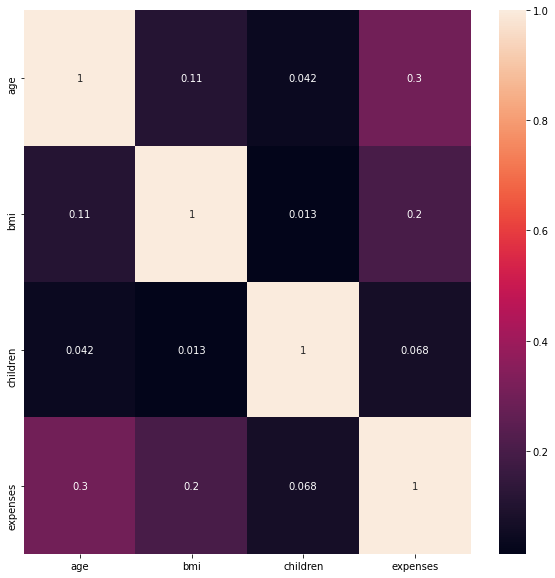

In [84]:
fig, ax = plt.subplots(figsize=(10,10))
corr = data.corr()
sns.heatmap(corr , annot = True , ax=ax)

Label Encode Object Types

In [85]:
d_types = dict(data.dtypes)
for name , type_ in d_types.items():
    if str(type_) == 'object':
        print(f"======== {name} ===========")
        print(data[name].value_counts())

======== sex ===========
male      676
female    662
Name: sex, dtype: int64
======== smoker ===========
no     1064
yes     274
Name: smoker, dtype: int64
======== region ===========
southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64


In [86]:
from sklearn.preprocessing import LabelEncoder
for name , type_ in d_types.items():
    if str(type_) == 'object':
        Le = LabelEncoder()
        data[name] = Le.fit_transform(data[name])

One hot Encoding 

In [47]:
from sklearn.preprocessing import OneHotEncoder

onehotencoder = OneHotEncoder()
part = onehotencoder.fit_transform(data['region'].values.reshape(-1,1)).toarray()

values = dict(data["region"].value_counts())

for e , (val , _) in enumerate(values.items()):
    data["region_" + str(val)] = part[:,e]

data = data.drop(["region"] , axis = 1)

data.head()
#data.info()

,age,sex,bmi,children,smoker,expenses,region_2,region_3,region_1,region_0
0,19,0,27.9,0,1,16884.92,0.0,0.0,0.0,1.0
1,18,1,33.8,1,0,1725.55,0.0,0.0,1.0,0.0
2,28,1,33.0,3,0,4449.46,0.0,0.0,1.0,0.0
3,33,1,22.7,0,0,21984.47,0.0,1.0,0.0,0.0
4,32,1,28.9,0,0,3866.86,0.0,1.0,0.0,0.0


Handle Skewness in Predictive column

In [48]:
Original_Y = data["expenses"].values.copy()
Original_Y

array([16884.92,  1725.55,  4449.46, ...,  1629.83,  2007.95, 29141.36])

Skewness in Column : Expenses  1.51587966289798


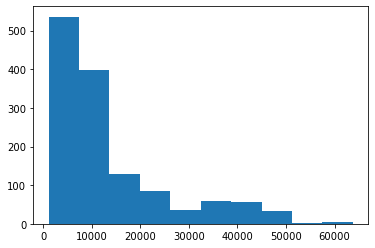

In [49]:
print("Skewness in Column : Expenses " , data["expenses"].skew())
plt.hist(data["expenses"])
plt.show()

Skewness in Column : Sqrt Expenses  0.7958625295340573


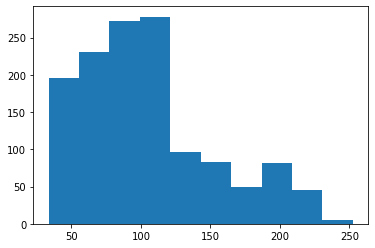

In [50]:
col_sqrt = np.sqrt(data["expenses"])
print("Skewness in Column : Sqrt Expenses " ,col_sqrt.skew())
plt.hist(col_sqrt)
plt.show()

Skewness in Column : boxcox Expenses  -0.008734062011873602


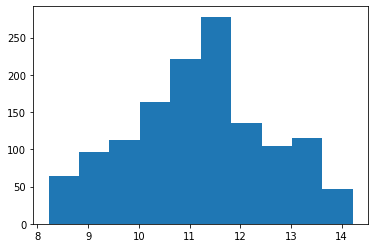

In [51]:
from scipy import stats 

col_cox , lam = stats.boxcox(data["expenses"])[0:2]
print("Skewness in Column : boxcox Expenses " ,pd.Series(col_cox).skew())
plt.hist(col_cox)
plt.show()

In [52]:
data["expenses"] = col_cox

Make Features and Targets

In [53]:
remaining_columns = list(data.columns)
remaining_columns.remove("expenses")

X = data[remaining_columns].values 
Y = data['expenses'].values

from sklearn.model_selection import train_test_split 
Xtrain , Xtest , Ytrain , Ytest = train_test_split(X , Y , test_size = 0.2 , random_state = 4)

from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()
Xtrain = Scaler.fit_transform(Xtrain)
Xtest = Scaler.transform(Xtest)

Xtrain.shape , Xtest.shape

((1070, 9), (268, 9))

## 正規化 check whether data is standardized (mean should be 1)

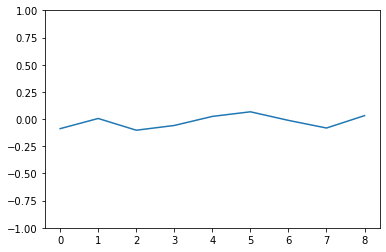

In [54]:
plt.ylim(-1,1)
means = []
for i in range(X.shape[1]):
    means.append(np.mean(Xtest[:,i]))
plt.plot(means , scaley=False)

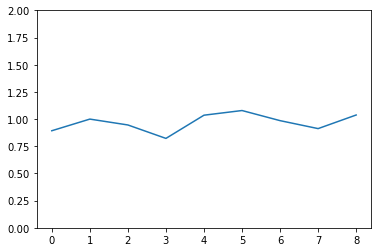

In [55]:
plt.ylim(0,2)
vars = []
for i in range(X.shape[1]):
    vars.append(np.var(Xtest[:,i]))
plt.plot(vars)

## Principal Component Analysis(PCA)  主成分分析：特徵擷取的一種方法

為降維(Dimension reduction)內特徵擷取(Feature extraction)的一種方法，降維就是希望資料的維度數減少，但整體的效能不會差異太多甚至會更好，降維（Dimensionality Reduction）是一種無監督學習，其最主要的目的是「化繁為簡」：將原本高維的數據（比方說 N 維）重新以一個相較低維的形式表達（比方說 K 維，且 K<N）。理想上只要該 K 維的表徵（representation）具有代表性，能夠抓住原來 N 維數據的大部分特性，我們就能在沒有損失什麼資訊的情況下，用更簡潔的方式呈現該組數據，進而對其本質有更深的理解。

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

pca = PCA(n_components = 7) #指定降維
Xtrain = pca.fit_transform(Xtrain)
Xtest = pca.transform(Xtest)
pca.explained_variance_ratio_.cumsum()

array([0.19330152, 0.35436043, 0.51529672, 0.64923641, 0.77679771,
       0.89223419, 1.        ])

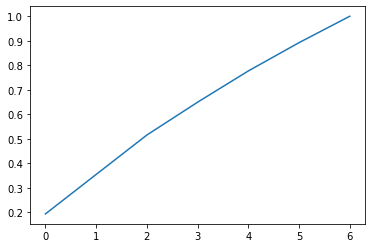

In [74]:
plt.plot(pca.explained_variance_ratio_.cumsum())

In [76]:
model = LinearRegression()
model.fit(Xtrain , Ytrain)
model.score(Xtest , Ytest) #測試與驗證

0.7497119096615363

## 交叉驗證(Cross validation)
一般來說我們會將數據分為兩個部分，一部分用來訓練，一部分用來測試，交叉驗證是一種統計學上將樣本切割成多個小子集的做測試與訓練。交叉驗證主要分為以下幾類：

- k-folder cross-vailation
- kk folder cross-vaildation
- least-one-out cross-validation
- 10-fold corss validation

In [77]:
from sklearn.model_selection import KFold 

k_fold = KFold(n_splits=5) #訓練了模型5次

test_scores = []
for train_idx , test_idx in k_fold.split(X):
    Xtrain = X[train_idx]
    Ytrain = Y[train_idx]

    Xtest = X[test_idx]
    Ytest = Y[test_idx]

    model = LinearRegression()
    model.fit(Xtrain , Ytrain)

    test_scores.append(model.score(Xtest , Ytest))

 mean score of k folds :  0.7667860542044181


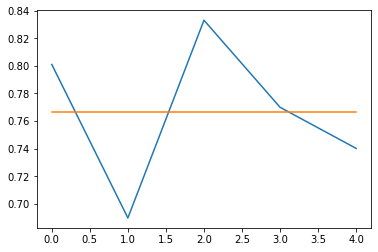

In [78]:
# 平均值決定了我們的全局分數，這意味著我們可以確信該模型的實時性能在這個數據集上就會出現。
# 0.76678 比我們之前的 0.7497 好

print(" mean score of k folds : " , np.mean(test_scores))
plt.plot(test_scores)
plt.plot([np.mean(test_scores)]*len(test_scores))
plt.show()

In [68]:
# Y = W.X + c
model.coef_.dot(Xtest[10,:]) + model.intercept_

9.853713595940004

In [69]:
model.predict(Xtest[10,:].reshape(1,-1))

array([9.8537136])

In [67]:
# rfecv.support_  #保留排名
# rfecv.ranking_  #重要度排名
# model.coef_ # 可查看係數
# model.intercept_ # 可查看截距值

Can we Bring back the data ?

In [62]:
from scipy.special import inv_boxcox
transformed_data = inv_boxcox(Y , lam)

In [63]:
transformed_data[:10]

array([16884.92,  1725.55,  4449.46, 21984.47,  3866.86,  3756.62,
        8240.59,  7281.51,  6406.41, 28923.14])

In [64]:
Original_Y[:10]

array([16884.92,  1725.55,  4449.46, 21984.47,  3866.86,  3756.62,
        8240.59,  7281.51,  6406.41, 28923.14])